Analysis of bank-additional.csv dataset
=======================================

# Data provenance (light)
The file [bank-additional.csv](bank-additional.csv) was provided as part of the [meetup on the 16 Nov 2016](https://www.meetup.com/Digital/events/233406302/).

There is no separate test set.

# Task
Predict 'y' (customer purchased product) based on other columns.

See [bank-additional-names.txt](bank-additional-names.txt) for further information.

# Setup

In [1]:
from IPython.display import display, HTML

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Make sure plots are shown inside the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

# Make random more predictable
random.seed(42)

In [3]:
# read in the data, semi-colon separated
raw_data = pd.read_csv('bank-additional.csv', sep=';')

# Drop context columns that seem to be generated in the future
raw_data = raw_data.drop(['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'], axis=1)

# Drop duration which also seem to be evaluated in the future
raw_data = raw_data.drop(['duration'], axis=1)

# print some basic stats
raw_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,2,999,0,nonexistent,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,4,999,0,nonexistent,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,1,999,0,nonexistent,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,3,999,0,nonexistent,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,1,999,0,nonexistent,no


In [4]:
raw_data.describe()

,age,campaign,pdays,previous
count,4119.000000,4119.000000,4119.000000,4119.000000
mean,40.113620,2.537266,960.422190,0.190337
std,10.313362,2.568159,191.922786,0.541788
min,18.000000,1.000000,0.000000,0.000000
25%,32.000000,1.000000,999.000000,0.000000
50%,38.000000,2.000000,999.000000,0.000000
75%,47.000000,3.000000,999.000000,0.000000
max,88.000000,35.000000,999.000000,6.000000


In [5]:
pd.DataFrame(raw_data.dtypes).transpose()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,y
0,int64,object,object,object,object,object,object,object,object,object,int64,int64,int64,object,object


From this we can see that non-numeric values are identified as 'object'.

Initial feature selection
-------------------------

In [6]:
data = raw_data.copy()

# Convert the 'y' (output) column, containing 'yes' or 'no', into a numeric value.
data['y'] = data['y'].map(lambda x: 1 if x == 'yes' else 0)

# Display data types
data['y'].dtypes

dtype('int64')

In [7]:
pd.DataFrame(data['y'].describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
y,4119.0,0.109493,0.312294,0.0,0.0,0.0,0.0,1.0


That means the rate is about 11% (always predicting false would already give us a good accuracy).

Show correlations with 'y' column
---------------------------------
(only includes numeric columns)

In [8]:
pd.DataFrame(data.corr()['y'].drop('y').sort_values(ascending=False)).transpose()

,previous,age,campaign,pdays
y,0.255697,0.060374,-0.076091,-0.332012


Select training / test data for the model
-----------------------------------------
We need to select only numeric columns for our model (as it may not be able to handle other types).

For simplicity, we are using train_test_split to split our data.
That means we are not training on all of our data and may end up having a lucky split.
Ideally we would use K-Fold test split (with multiple runs).

In [9]:
data_numeric = data.select_dtypes(include=[np.number])
print("Numeric columns:", data_numeric.columns.values)
X = data_numeric.drop('y', axis=1)
Y = data_numeric['y']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

Numeric columns: ['age' 'campaign' 'pdays' 'previous' 'y']
X_train shape: (3089, 4)
Y_train shape: (3089,)
X_test shape: (1030, 4)
Y_test shape: (1030,)


### Computer says 'no' model
(the model to beat)

In [10]:
pred_train = [0 for row in Y_train]
pred_test = [0 for row in Y_test]

print("Predict 'no' (train), accuracy:", accuracy_score(Y_train, pred_train), ", mse:", mean_squared_error(Y_train, pred_train))
print("Predict 'no' (test), accuracy:", accuracy_score(Y_test, pred_test), ", mse:", mean_squared_error(Y_test, pred_test))


Predict 'no' (train), accuracy: 0.887665911298 , mse: 0.112334088702
Predict 'no' (test), accuracy: 0.899029126214 , mse: 0.100970873786


LogisticRegression
------------------
LogisticRegression is a simple classifier.

In [11]:
model = LogisticRegression()
model.fit(X_train, Y_train)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

print("Train, accuracy:", accuracy_score(Y_train, pred_train), ", mse:", mean_squared_error(Y_train, pred_train))
print("Test, accuracy:", accuracy_score(Y_test, pred_test), ", mse:", mean_squared_error(Y_test, pred_test))

Train, accuracy: 0.898348980253 , mse: 0.101651019747
Test, accuracy: 0.906796116505 , mse: 0.0932038834951


Only a tiny bit better than always predicting 'no'.

In [12]:
print("intercept:", model.intercept_)

intercept: [-0.11437619]


In [13]:
pd.DataFrame(pd.Series(model.get_params(deep=True))).transpose()

,C,class_weight,dual,fit_intercept,intercept_scaling,max_iter,multi_class,n_jobs,penalty,random_state,solver,tol,verbose,warm_start
0,1,None,False,True,1,100,ovr,1,l2,None,liblinear,0.0001,0,False


### Learned coefficients

In [14]:
coeffs = pd.Series(model.coef_[0], index=X_train.columns).sort_values()
pd.DataFrame(coeffs).transpose()

,campaign,pdays,age,previous
0,-0.127497,-0.002455,0.01264,0.294849


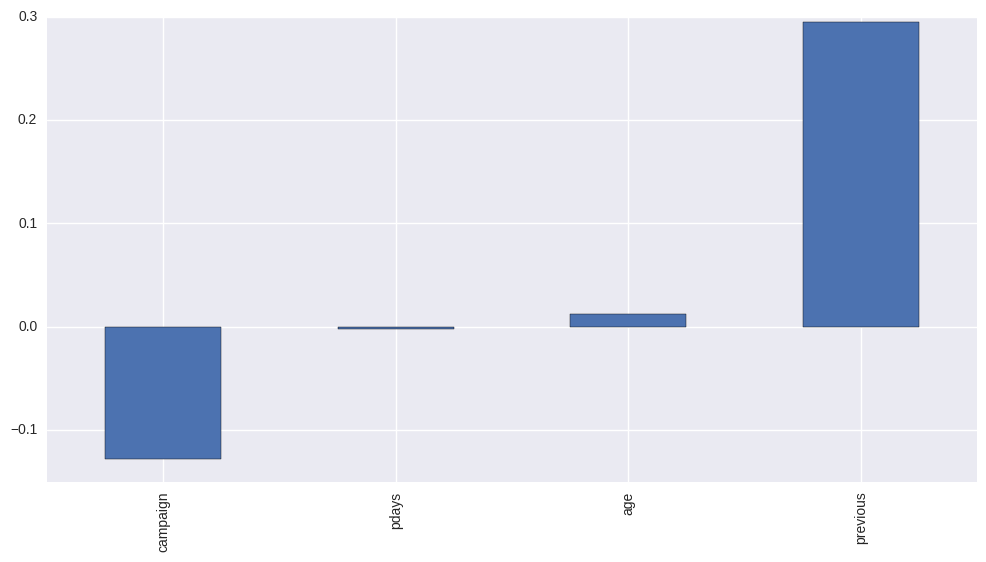

In [15]:
coeffs.plot(kind="bar", figsize=(12, 6))

Possible interpretation: better not contact the client too frequently during a campaign but keep in touch in the long run.

## How does a Random Forest Classifier do

In [16]:
model = RandomForestClassifier()
model.fit(X_train, Y_train)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

print("Train, accuracy:", accuracy_score(Y_train, pred_train), ", mse:", mean_squared_error(Y_train, pred_train))
print("Test, accuracy:", accuracy_score(Y_test, pred_test), ", mse:", mean_squared_error(Y_test, pred_test))

Train, accuracy: 0.920038847523 , mse: 0.0799611524765
Test, accuracy: 0.898058252427 , mse: 0.101941747573


It seems to overfit on the training set but does not impress on the test set.

Add dummy columns for categorical columns
=================
(For simplicity, code is repeated - don't do that at home)

In [17]:
# For the purpose of this example we treat anything of the type 'object' as categorical
cat_columns = data.select_dtypes(include=['object']).columns.values
for cat_column in cat_columns:
  data = data.drop(cat_column, axis=1).join(pd.get_dummies(data[cat_column], prefix=cat_column))

# Display types
pd.DataFrame(data.dtypes).transpose()

,age,campaign,pdays,previous,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,int64,int64,int64,int64,int64,uint8,uint8,uint8,uint8,uint8,...,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8


## Print the correlations again

In [18]:
pd.DataFrame(data.corr()['y'].drop('y').sort_values(ascending=False)).transpose()

,poutcome_success,previous,month_mar,contact_cellular,month_sep,month_oct,month_dec,job_retired,default_no,age,...,marital_married,month_jul,education_basic.9y,job_blue-collar,campaign,default_unknown,month_may,contact_telephone,poutcome_nonexistent,pdays
y,0.325804,0.255697,0.164775,0.137401,0.119395,0.105684,0.102309,0.078373,0.076567,0.060374,...,-0.036197,-0.038779,-0.044561,-0.067781,-0.076091,-0.076388,-0.100321,-0.137401,-0.207179,-0.332012


## Split data into training / test data

In [19]:
data_numeric = data.select_dtypes(include=[np.number])
print("Numeric columns:", data_numeric.columns.values)
X = data_numeric.drop('y', axis=1)
Y = data_numeric['y']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

Numeric columns: ['age' 'campaign' 'pdays' 'previous' 'y' 'job_admin.' 'job_blue-collar'
 'job_entrepreneur' 'job_housemaid' 'job_management' 'job_retired'
 'job_self-employed' 'job_services' 'job_student' 'job_technician'
 'job_unemployed' 'job_unknown' 'marital_divorced' 'marital_married'
 'marital_single' 'marital_unknown' 'education_basic.4y'
 'education_basic.6y' 'education_basic.9y' 'education_high.school'
 'education_illiterate' 'education_professional.course'
 'education_university.degree' 'education_unknown' 'default_no'
 'default_unknown' 'default_yes' 'housing_no' 'housing_unknown'
 'housing_yes' 'loan_no' 'loan_unknown' 'loan_yes' 'contact_cellular'
 'contact_telephone' 'month_apr' 'month_aug' 'month_dec' 'month_jul'
 'month_jun' 'month_mar' 'month_may' 'month_nov' 'month_oct' 'month_sep'
 'day_of_week_fri' 'day_of_week_mon' 'day_of_week_thu' 'day_of_week_tue'
 'day_of_week_wed' 'poutcome_failure' 'poutcome_nonexistent'
 'poutcome_success']
X_train shape: (3089, 57)
Y_train

## Logist regression

In [20]:
model = LogisticRegression()
model.fit(X_train, Y_train)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

print("Train, accuracy:", accuracy_score(Y_train, pred_train), ", mse:", mean_squared_error(Y_train, pred_train))
print("Test, accuracy:", accuracy_score(Y_test, pred_test), ", mse:", mean_squared_error(Y_test, pred_test))

Train, accuracy: 0.906442214309 , mse: 0.0935577856912
Test, accuracy: 0.888349514563 , mse: 0.111650485437


In [21]:
# Display model params
pd.DataFrame(pd.Series(model.get_params(deep=True))).transpose()

,C,class_weight,dual,fit_intercept,intercept_scaling,max_iter,multi_class,n_jobs,penalty,random_state,solver,tol,verbose,warm_start
0,1,None,False,True,1,100,ovr,1,l2,None,liblinear,0.0001,0,False


In [22]:
# Display the intercept
print("intercept:", model.intercept_)

intercept: [-0.58890126]


### What coefficients did the logistic regression learn?

In [23]:
coeffs = pd.Series(model.coef_[0], index=X_train.columns).sort_values()
pd.DataFrame(coeffs).transpose()

,month_nov,month_aug,poutcome_failure,contact_telephone,month_jul,month_may,job_unknown,job_entrepreneur,poutcome_nonexistent,job_management,...,education_university.degree,month_sep,job_unemployed,contact_cellular,previous,month_jun,job_student,poutcome_success,month_mar,month_dec
0,-1.112391,-1.091466,-0.977879,-0.902485,-0.886342,-0.764363,-0.514885,-0.490693,-0.447499,-0.427774,...,0.169658,0.254949,0.301588,0.313584,0.45157,0.496897,0.522449,0.836477,1.247178,1.440741


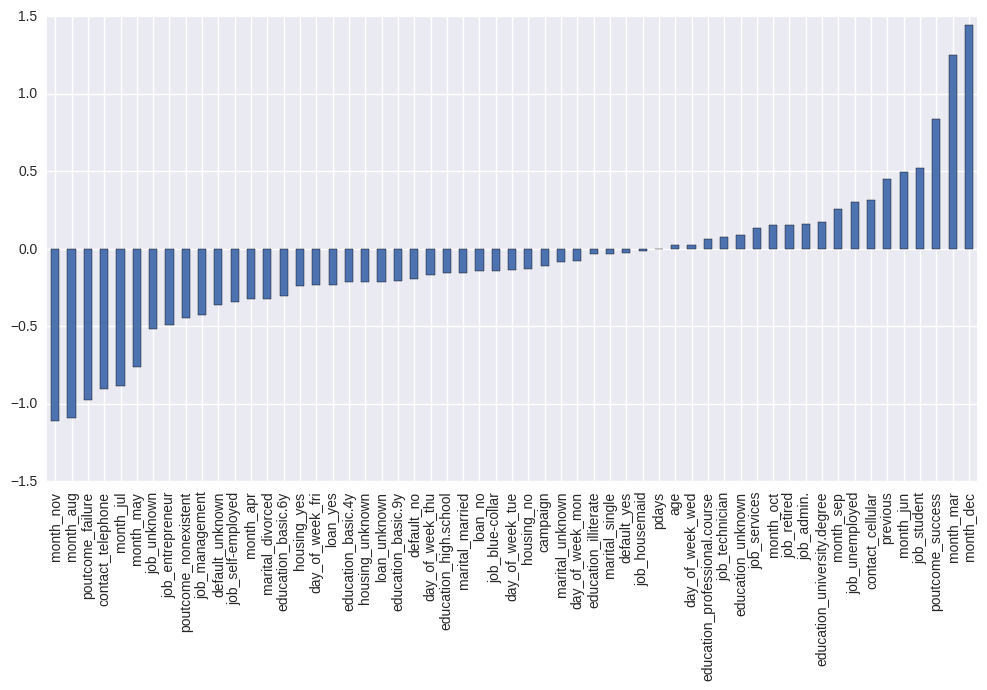

In [24]:
coeffs.plot(kind="bar", figsize=(12, 6))

Looks like some months are worse than others. Do we have an even distribution?

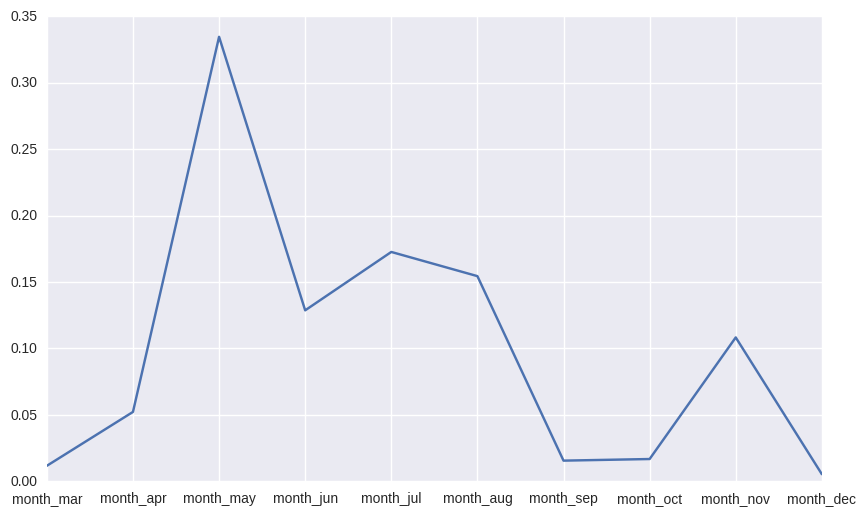

In [25]:
# January and Feburary do not seem to be in the dataset, include the months that are
data[[
  "month_mar", "month_apr", "month_may", "month_jun" , "month_jul", "month_aug", "month_sep", "month_oct", "month_nov", "month_dec"
]].mean().plot()

Probably not, using the month may not be the best predictor.

## Random Forest

In [26]:
model = RandomForestClassifier()
model.fit(X_train, Y_train)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

print("Train, accuracy:", accuracy_score(Y_train, pred_train), ", mse:", mean_squared_error(Y_train, pred_train))
print("Test, accuracy:", accuracy_score(Y_test, pred_test), ", mse:", mean_squared_error(Y_test, pred_test))

Train, accuracy: 0.984784719974 , mse: 0.0152152800259
Test, accuracy: 0.883495145631 , mse: 0.116504854369


Conclusion so far
=================

Always predicting 'no' would arguably be the simplest model.
The model without the categorical features has a similar accuracy.
Adding categorical features doesn't seem to improve the accuracy significantly.

# Next steps
* Look at data in more detail and engineer more features, polynomial etc.
* Try different models
* Do we have enough data?